In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("/n/home13/wcarvalho/projects/marl")
print("at directory:", os.getcwd())

at directory: /n/home13/wcarvalho/results/jaxrl_results
changing to root directory
at directory: /n/home13/wcarvalho/projects/marl


In [3]:
import jax
import jax.numpy as jnp
import functools
import pandas as pd
import numpy as np
from glob import glob

from projects.humansf import housemaze_analysis
from projects.humansf import trainer_housemaze
from projects.humansf import housemaze_experiments
from projects.humansf import networks
from housemaze import renderer
from housemaze import utils
from housemaze.human_dyna import env as maze
from library import launcher
from agents import value_based_basics as vbb


/n/home13/wcarvalho/.conda/envs/jaxneurorl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/n/home13/wcarvalho/.local/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


# Setup Environment

In [4]:
# exp = 'maze3_randomize'
image_dict = utils.load_image_dict()

def housemaze_render_fn(state: maze.EnvState):
    return renderer.create_image_from_grid(
        state.grid,
        state.agent_pos,
        state.agent_dir,
        image_dict)

exp = 'maze3_open'
exp_fn = getattr(housemaze_experiments, exp, None)
_, default_env_params, task_objects = exp_fn({})


No file specified for image dict.
Using: /n/home13/wcarvalho/projects/marl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /n/home13/wcarvalho/projects/marl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


In [5]:
task_runner = maze.TaskRunner(task_objects=task_objects)
env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=200,
)
env = utils.AutoResetWrapper(env)

In [6]:
parallel_envs = 25

train_objects = default_env_params.reset_params.train_objects[0, :2]
test_objects = default_env_params.reset_params.test_objects[0, :2]

train_ws = jnp.array([task_runner.task_vector(o) for o in train_objects])
test_ws = jnp.array([task_runner.task_vector(o) for o in test_objects])

print(train_objects, test_objects)
print(train_ws, test_ws)


[26] [40]
[[1 0]] [[0 1]]


In [7]:
from housemaze.human_dyna import mazes

char2key, group_set, task_objects = housemaze_experiments.get_group_set(1)

No file specified for image dict.
Using: /n/home13/wcarvalho/projects/marl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


In [38]:
maze3_params = mazes.get_maze_reset_params(
    group_set=group_set,
    char2key=char2key,
    maze_str=mazes.maze3,
    randomize_agent=False,
    make_env_params=True,
)
maze3_open_params = mazes.get_maze_reset_params(
    group_set=group_set,
    char2key=char2key,
    maze_str=mazes.maze3_open,
    randomize_agent=False,
    make_env_params=True,
)


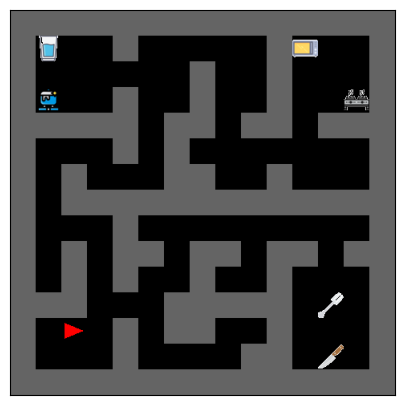

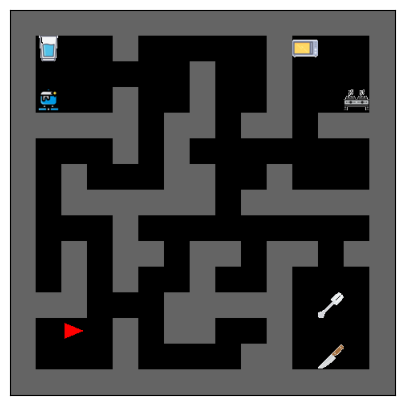

In [152]:
def render_env(env_params):
    map_init = jax.tree_map(lambda x:x[0], env_params.reset_params.map_init)
    grid = np.asarray(map_init.grid)    
    actions = utils.actions_from_path(positions)
    img = renderer.create_image_from_grid(
        map_init.grid,
        map_init.agent_pos,
        map_init.agent_dir,
        image_dict)
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(img)
    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
render_env(maze3_params)
render_env(maze3_open_params)

# Load agents

In [9]:
results = dict()
df = 

In [130]:
success_fn = jax.jit(jax.vmap(housemaze_analysis.success))
def add_model_results(key: str, algorithm, env_params, train: bool = False, df=None, reset=False):
    if reset:
        results.clear()
    if key in results: return df
    eval_fn = algorithm.eval_fn
    rng = jax.random.PRNGKey(42)
    if train:
        objs = maze3_params.reset_params.train_objects
    else:
        objs = maze3_params.reset_params.test_objects

    for o in objs:
        task_w = task_runner.task_vector(o)
        trajs = eval_fn(rng, env_params, task_w)
        trajs = jax.tree_map(lambda x: x[0], trajs) # only had 1 task
        total_rewards, success_rates = success_fn(trajs.timestep)
        
        results[key] = trajs
        lengths = jnp.argmax(trajs.timestep.last(), 1)+1
        ntraj = len(total_rewards)
        metrics = dict(
            algo=[algorithm.name]*ntraj,
            key=[key]*ntraj,
            train=[train]*ntraj,
            sr=success_rates,
            tr=total_rewards,
            pl=lengths,
        )

        new_df = pd.DataFrame(metrics)
        if reset:
            return new_df
        if df is not None :
            df = pd.concat([df, new_df], ignore_index=True)
        else:
            df = new_df
    return df

def add_search_results(key: str, algo, env_params, df, budget=1e8, train: bool = False, ntraj = 100, force: bool = False):
    if key in results and not force: return df

    if train:
        objs = env_params.reset_params.train_objects
    else:
        objs = env_params.reset_params.test_objects
    
    map_init = jax.tree_map(lambda x:x[0], env_params.reset_params.map_init)
    grid = np.asarray(map_init.grid)
    agent_pos = tuple(int(o) for o in map_init.agent_pos)
    trajectories = []
    for o in objs:
        goal = np.array([o])
        success_rates = []
        total_rewards = []
        path_lengths = []
        for idx in range(ntraj):
            path, iterations = algo(grid, agent_pos, goal, key=jax.random.PRNGKey(idx), budget=budget)
            trajectories.append(path)
            if path is None:
                success_rates.append(0)
                total_rewards.append(0)
                path_lengths.append(np.inf)
            else:
                success_rates.append(1)
                total_rewards.append(1)
                path_lengths.append(len(path))
        
        results[key] = trajectories
        metrics = dict(
            algo=['bfs']*ntraj,
            key=[key]*ntraj,
            train=[train]*ntraj,
            sr=success_rates,
            tr=total_rewards,
            pl=path_lengths,
        )

        new_df = pd.DataFrame(metrics)
        return pd.concat([df, new_df], ignore_index=True)


In [53]:
def test(algorithm, visualize: bool = False):
    
    def collect(example_w):
        rng = jax.random.PRNGKey(41)
        trajs = algorithm.eval_fn(rng, maze3_params, example_w)
        trajs = jax.tree_map(lambda x: x[0], trajs) # only had 1 task
        
        return trajs, success_fn(trajs.timestep)
    example_w = task_runner.task_vector(maze3_params.reset_params.train_objects[0])
    tasjs, (total_rewards, success_rates) = collect(example_w)
    # print('Train average total rewards =', total_rewards.mean())
    print('Train average success rate =', success_rates.mean())
    
    example_w = task_runner.task_vector(maze3_params.reset_params.test_objects[0])
    tasjs, (total_rewards, success_rates) = collect(example_w)
    # print('Test average total rewards =', total_rewards.mean())
    print('Test average success rate =', success_rates.mean())
    
    if visualize:
        housemaze_analysis.plot_timesteps(
          jax.tree_map(lambda x:x[0], trajs),
          render_fn=housemaze_render_fn,
          get_task_name=functools.partial(trainer_housemaze.task_from_variables, keys=image_dict['keys']),
          extract_task_info=trainer_housemaze.extract_task_info,
          max_len=50)

### Q-learning

In [10]:
# REAL RUNS
# !ls /n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/*/*/qlearning.safetensors

In [12]:
qlearning = housemaze_analysis.load_algorithm(
    path='/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/ql/save_data/ql-15/exp=maze3_open',
    name='qlearning',
    make_fns=trainer_housemaze.get_qlearning_fns,
    env=env,
    env_params=default_env_params,
    parallel_envs=parallel_envs,
)



In [18]:
test(qlearning)

Train average total rewards = 1.0
Train average success rate = 1.0
Test average total rewards = 0.0
Test average success rate = 0.0


## Dyna

In [21]:
# REAL RUNS
# !ls /n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/dynaq_shared/save_data/*/*/*.safetensors

In [23]:
# path = '/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/dynaq_shared/save_data/dynaq_shared-10/ALG=dynaq_shared,DYNA=1,LR=0.0003,LR_L=False,STOP=False,TOTA=20000000,exp=maze3_open'
path = glob(os.path.join(
    '/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/dynaq_shared/save_data',
    '*/',
    'ALG=dynaq_shared,DYNA=1,LR=0.0003,LR_L=False,STOP=False,TOTA=20000000,exp=maze3_open'
))[0]

/n/home13/wcarvalho/results/jaxrl_results/trainer_housemaze/dynaq_shared/save_data/dynaq_shared-10/ALG=dynaq_shared,DYNA=1,LR=0.0003,LR_L=False,STOP=False,TOTA=20000000,exp=maze3_open


In [24]:
dyna = housemaze_analysis.load_algorithm(
    path=path,
    name='dynaq_shared',
    make_fns=functools.partial(trainer_housemaze.get_dynaq_fns,
        env=env,
        env_params=default_env_params,
        task_objects=task_objects),
    env=env,
    env_params=default_env_params,
    parallel_envs=parallel_envs,
)



In [54]:
test(dyna)

Train average success rate = 1.0
Test average success rate = 1.0


## Get results

In [ ]:
# df = add_model_results('ql_maze3_task', qlearning, maze3_params, train=True, reset=True)
results = dict()

(        algo            key  train   sr   tr  pl
 0  qlearning  ql_maze3_task   True  1.0  1.0  35
 1  qlearning  ql_maze3_task   True  1.0  1.0  35
 2  qlearning  ql_maze3_task   True  1.0  1.0  35
 3  qlearning  ql_maze3_task   True  1.0  1.0  35
 4  qlearning  ql_maze3_task   True  1.0  1.0  35,
 100)

In [61]:
idx = 0
for train in [
    True,
    False
]:
    for maze, name in [
        (maze3_params, 'maze3'),
        (maze3_open_params, 'maze3_open')
    ]:
        for algorithm in [qlearning, dyna]:
            df = add_model_results(f'{algorithm.name}_{name}_train={train}', algorithm, maze, train=train, df=df, reset=idx==0)
            idx += 1

In [62]:
sorted(list(df['key'].unique()))

['dynaq_shared_maze3_open_train=False',
 'dynaq_shared_maze3_open_train=True',
 'dynaq_shared_maze3_train=False',
 'dynaq_shared_maze3_train=True',
 'qlearning_maze3_open_train=False',
 'qlearning_maze3_open_train=True',
 'qlearning_maze3_train=False',
 'qlearning_maze3_train=True']

In [45]:
# df = add_model_results('dyna_maze3_offtask', dyna, maze3_params, train=False, df=df)
# df.head(), len(df)

# Search results

In [132]:
idx = 0
for budget in [
    150,
    # 1000
]:
    for maze, name in [
        # (maze3_params, 'maze3'),
        (maze3_open_params, 'maze3_open')
    ]:
        for algo in [
            # 'bfs',
            'dfs'
        ]:
            fn = getattr(utils, algo)
            df = add_search_results(f'{algo}_{name}_{budget}_train=False', algo=fn, df=df, env_params=maze, budget=budget, train=False, force=True)
            idx += 1
            print(idx)

1


In [64]:
sorted(list(df['key'].unique()))

['bfs_maze3_1000_train=False',
 'bfs_maze3_150_train=False',
 'bfs_maze3_open_1000_train=False',
 'bfs_maze3_open_150_train=False',
 'dfs_maze3_1000_train=False',
 'dfs_maze3_150_train=False',
 'dfs_maze3_open_1000_train=False',
 'dfs_maze3_open_150_train=False',
 'dynaq_shared_maze3_open_train=False',
 'dynaq_shared_maze3_open_train=True',
 'dynaq_shared_maze3_train=False',
 'dynaq_shared_maze3_train=True',
 'qlearning_maze3_open_train=False',
 'qlearning_maze3_open_train=True',
 'qlearning_maze3_train=False',
 'qlearning_maze3_train=True']

In [31]:
# budget=150
# df = add_search_results(f'bfs_maze3_offtask_{budget}', algo=utils.bfs, df=df, env_params=maze3_params, budget=budget, train=False)
# df = add_search_results(f'dfs_maze3_offtask_{budget}', algo=utils.dfs, df=df, env_params=maze3_params, budget=budget, train=False)

# Plots

In [33]:
sorted(list(df['key'].unique()))

array(['ql_maze3_task', 'ql_maze3_offtask', 'dyna_maze3_task',
       'dyna_maze3_offtask', 'bfs_maze3_offtask', 'dfs_maze3_offtask',
       'bfs_maze3_offtask_150', 'dfs_maze3_offtask_150'], dtype=object)

### Signature 1: Offtask-Dyna will succeed on getting to a task that wasn't a train task
### Signature 2: DFS will take the optimal path, Offtask-Dyna will take the long path

/tmp/ipykernel_1579063/3570103486.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right')
/tmp/ipykernel_1579063/3570103486.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right')


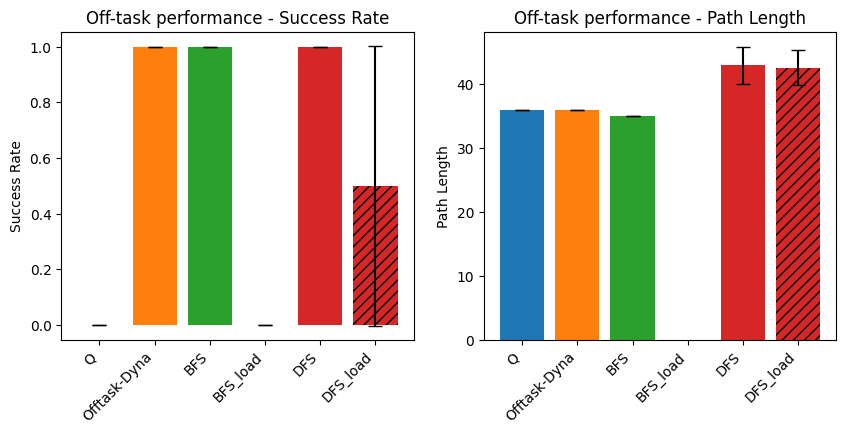

In [155]:
import matplotlib.pyplot as plt

def create_bar_plot(ax, data_dict, ylabel='Success Rates', title='', color_dict=None, hatches_dict=None):
    names = list(data_dict.keys())
    values = [v[0] for v in data_dict.values()]  # Means
    errors = [v[1] for v in data_dict.values()]  # Standard deviations
    
    colors = [color_dict[name.split('_')[0]] for name in names] if color_dict else None
    hatches = [hatches_dict.get(name, '') for name in names] if hatches_dict else None
    
    bars = ax.bar(names, values, yerr=errors, capsize=5, color=colors)
    
    # Apply hatches after creating bars
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(names, ha='right')

def get(key, val):
    data = df[(df['key'] == key)][val]
    # Filter out inf and nan values
    finite_data = data[np.isfinite(data)]
    if len(finite_data) > 0:
        mean = finite_data.mean()
        std = finite_data.std()
    else:
        mean = np.nan
        std = np.nan
    return mean, std

# nrows = 2
# ncols = 2
# base = 5
# fig, axs = plt.subplots(nrows, ncols, figsize=(nrows*base, ncols*base))
# axs = axs.ravel()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.ravel()

# Example usage
color_dict = {
    'Q': '#1f77b4',  # blue
    'Offtask-Dyna': '#ff7f0e',  # orange
    'BFS': '#2ca02c',  # green
    'BFS_load': '#2ca02c',  # green
    'DFS': '#d62728',  # red
    'DFS_load': '#d62728',  # red
}

hatches_dict = {
    'BFS_load': '///',
    'DFS_load': '///'
}

for i, val in enumerate(['sr', 'pl']):
    data = {
        'Q': get('qlearning_maze3_train=False', val),
        'Offtask-Dyna': get('dynaq_shared_maze3_train=True', val),
        'BFS': get('bfs_maze3_1000_train=False', val),
        'BFS_load': get('bfs_maze3_150_train=False', val),
        'DFS': get('dfs_maze3_1000_train=False', val),
        'DFS_load': get('dfs_maze3_150_train=False', val),
    }
    ylabel = dict(
        sr='Success Rate',
        pl='Path Length',
    )[val]
    create_bar_plot(
        axs[i],
        data,
        title=f'Off-task performance - {ylabel}',
        color_dict=color_dict,
        hatches_dict=hatches_dict,
        ylabel=ylabel,
    )
    
    
# for i, val in enumerate(['sr', 'pl']):
#     data = {
#         'Q': get('qlearning_maze3_open_train=False', val),
#         'Offtask-Dyna': get('dynaq_shared_maze3_open_train=True', val),
#         'BFS': get('bfs_maze3_open_1000_train=False', val),
#         'BFS_load': get('bfs_maze3_open_150_train=False', val),
#         'DFS': get('dfs_maze3_open_1000_train=False', val),
#         'DFS_load': get('dfs_maze3_open_150_train=False', val),
#     }
#     ylabel = dict(
#         sr='Success Rate',
#         pl='Path Length',
#     )[val]
#     create_bar_plot(
#         axs[i+2],
#         data,
#         title=f'Off-task performance (Open Shortcut) - {ylabel}',
#         color_dict=color_dict,
#         hatches_dict=hatches_dict,
#         ylabel=ylabel,
#     )

# plt.tight_layout()
# plt.show()

### Signature: DFS will take the optimal path, Offtask-Dyna will take the long path

/tmp/ipykernel_1579063/3570103486.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right')
/tmp/ipykernel_1579063/3570103486.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, ha='right')


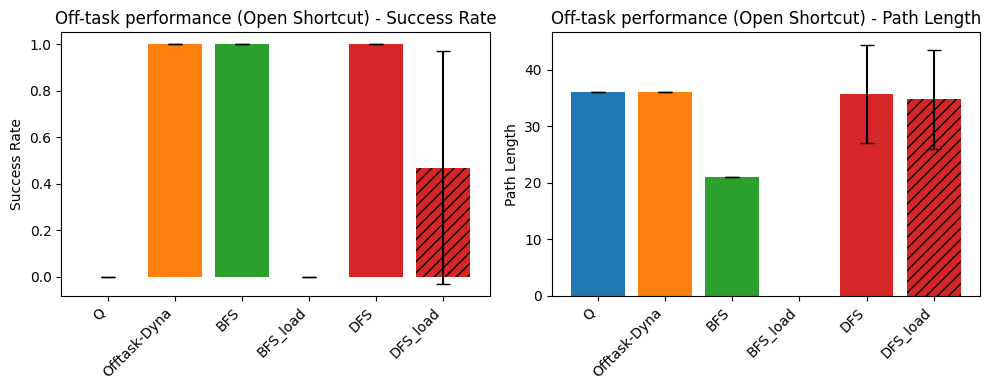

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.ravel()

# Example usage
color_dict = {
    'Q': '#1f77b4',  # blue
    'Offtask-Dyna': '#ff7f0e',  # orange
    'BFS': '#2ca02c',  # green
    'BFS_load': '#2ca02c',  # green
    'DFS': '#d62728',  # red
    'DFS_load': '#d62728',  # red
}

hatches_dict = {
    'BFS_load': '///',
    'DFS_load': '///'
}

for i, val in enumerate(['sr', 'pl']):
    data = {
        'Q': get('qlearning_maze3_open_train=False', val),
        'Offtask-Dyna': get('dynaq_shared_maze3_open_train=True', val),
        'BFS': get('bfs_maze3_open_1000_train=False', val),
        'BFS_load': get('bfs_maze3_open_150_train=False', val),
        'DFS': get('dfs_maze3_open_1000_train=False', val),
        'DFS_load': get('dfs_maze3_open_150_train=False', val),
    }
    ylabel = dict(
        sr='Success Rate',
        pl='Path Length',
    )[val]
    create_bar_plot(
        axs[i],
        data,
        title=f'Off-task performance (Open Shortcut) - {ylabel}',
        color_dict=color_dict,
        hatches_dict=hatches_dict,
        ylabel=ylabel,
    )

plt.tight_layout()
plt.show()

In [74]:
# show off-task dyna path

sorted(list(results.keys()))

['bfs_maze3_1000_train=False',
 'bfs_maze3_150_train=False',
 'bfs_maze3_open_1000_train=False',
 'bfs_maze3_open_150_train=False',
 'dfs_maze3_1000_train=False',
 'dfs_maze3_150_train=False',
 'dfs_maze3_open_1000_train=False',
 'dfs_maze3_open_150_train=False',
 'dynaq_shared_maze3_open_train=False',
 'dynaq_shared_maze3_open_train=True',
 'dynaq_shared_maze3_train=False',
 'dynaq_shared_maze3_train=True',
 'qlearning_maze3_open_train=False',
 'qlearning_maze3_open_train=True',
 'qlearning_maze3_train=False',
 'qlearning_maze3_train=True']

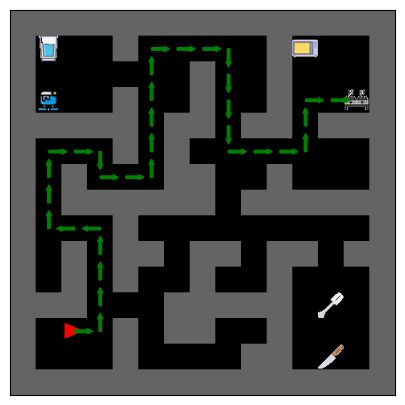

In [165]:
def render_model_path(traj, ep_idx = 0, ax=None):
    # get actions that are in episode
    in_episode = housemaze_analysis.get_in_episode(traj.timestep)[ep_idx]
    actions = traj.action[ep_idx][in_episode][:-1]
    # positions in episode
    positions = jax.tree_map(lambda x: x[ep_idx][in_episode][:-1], traj.timestep.state.agent_pos)

    state_0 = jax.tree_map(lambda x: x[ep_idx, 0], traj.timestep.state)
    
    # doesn't matter
    maze_height, maze_width, _ = traj.timestep.state.grid[0,0].shape
    
    fig, ax = plt.subplots(1, figsize=(5, 5))
    img = housemaze_render_fn(state_0)
    renderer.place_arrows_on_image(img, positions, actions, maze_height, maze_width, arrow_scale=5, ax=ax)

render_model_path(results['dynaq_shared_maze3_open_train=False'])

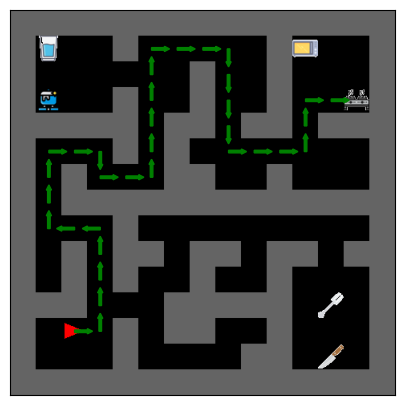

In [166]:
render_model_path(results['dynaq_shared_maze3_train=False'])

[1784718894 3813648515]
83


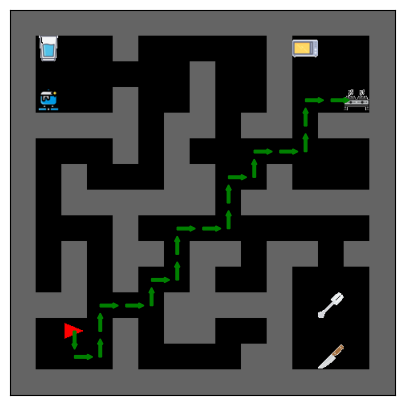

In [195]:
def collect_search_success(env_params, algo, budget=150, seed=0):
    objs = env_params.reset_params.test_objects

    map_init = jax.tree_map(lambda x:x[0], env_params.reset_params.map_init)
    grid = np.asarray(map_init.grid)
    agent_pos = tuple(int(o) for o in map_init.agent_pos)

    path = None
    o = objs[0]
    goal = np.array([o])
    rng = jax.random.PRNGKey(seed)
    while path is None:
        rng, rng_ = jax.random.split(rng)
        print(rng_)
        path, iterations = algo(grid, agent_pos, goal, key=rng_, budget=budget)
    print(iterations)
    return path

def render_search_path(positions, env_params):
    map_init = jax.tree_map(lambda x:x[0], env_params.reset_params.map_init)
    grid = np.asarray(map_init.grid)    
    actions = utils.actions_from_path(positions)
    
    # doesn't matter
    maze_height, maze_width, _ = grid.shape
    
    img = renderer.create_image_from_grid(
        map_init.grid,
        map_init.agent_pos,
        map_init.agent_dir,
        image_dict)
    renderer.place_arrows_on_image(img, positions, actions, maze_height, maze_width)

env_params = maze3_open_params
budget = 150
path = collect_search_success(env_params=env_params, algo=utils.dfs, budget=budget, seed=5)
render_search_path(path, env_params)